In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import itertools

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
config_file = '../snakemake/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
filt_ab = '../'+expand(config['data']['filt_ab'], species='human')[0]
lib_meta = '../'+expand(config['data']['meta'], species='human')[0]
cerberus_h5 = '../'+expand(config['data']['cerb_annot'], species='human')[0]
ca_plus = '../'+expand(config['data']['ca_plus'], species='human')[0]
swan_file = '../'+expand(config['data']['sg'], species='human')[0]
gtf = '../'+expand(config['data']['cerb_gtf'], species='human')[0]

phastcons = '../'+config['ref']['phastcons100']['txt']

gene_subset = 'polya'

biosamp_name_map = '../'+expand(config['ref']['biosamp_map'])[0]

cage_meta = '../'+expand(config['cage']['meta'], species='human')[0]
rampage_meta = '../'+expand(config['rampage']['meta'], species='human')[0]

min_tpm = 1
gene_subset = 'protein_coding'

In [20]:
source = 'obs_det'

In [16]:
ca = cerberus.read(cerberus_h5)
biotype_info, _, _ = get_gtf_info(add_stable_gid=True)
gids = biotype_info.loc[biotype_info.biotype==gene_subset, 'gid_stable'].tolist()
ca.triplets = ca.triplets.loc[ca.triplets.gid.isin(gids)]

## 230811 limit to one tss / tes pair per gene

In [141]:
gtf_df = pr.read_gtf(gtf, rename_attr=True, duplicate_attr=True).as_df()
exons = gtf_df.loc[gtf_df.Feature=='exon']
keep_cols = ['gene_id', 'gene_name', 'transcript_id', 'Start']
gb_cols = ['gene_id', 'gene_name', 'transcript_id']
exons = exons[keep_cols].groupby(gb_cols).count().reset_index().rename({'Start': 'n_exons'}, axis=1)

# retain the isoform w/ the max # of isoforms
exons = exons.sort_values(by='n_exons', ascending=False)
exons = exons[['gene_id', 'gene_name', 'n_exons']].drop_duplicates(subset=['gene_id', 'gene_name'], keep='first')

# remove monoexonic and biexonoic
exons = exons.loc[exons.n_exons>2]

exons['theor_max_isos'] = (2**(exons['n_exons']-2))

Found attributes with reserved names: ['source'].
Renaming attributes with suffix '_attr'


In [142]:
exons.head()

,gene_id,gene_name,n_exons,theor_max_isos
77152,ENSG00000127481.14,UBR4,106,0
53775,ENSG00000112159.11,MDN1,102,0
105923,ENSG00000142798.19,HSPG2,97,0
78659,ENSG00000128731.16,HERC2,93,0
71518,ENSG00000123384.13,LRP1,89,0


## How many potential isoforms would result from truly stochastic inclusion / exclusion of exons for each gene?

In [4]:
gtf_df = pr.read_gtf(gtf, rename_attr=True, duplicate_attr=True).as_df()

Found attributes with reserved names: ['source'].
Renaming attributes with suffix '_attr'


In [89]:
exons = gtf_df.loc[gtf_df.Feature=='exon']
keep_cols = ['gene_id', 'gene_name', 'transcript_id', 'Start']
gb_cols = ['gene_id', 'gene_name', 'transcript_id']
exons = exons[keep_cols].groupby(gb_cols).count().reset_index().rename({'Start': 'n_exons'}, axis=1)

In [90]:
exons.loc[exons.gene_name=='COL1A1']

,gene_id,gene_name,transcript_id,n_exons
48244,ENSG00000108821.13,COL1A1,"ENSG00000108821[1,1,12]",51
48245,ENSG00000108821.13,COL1A1,"ENSG00000108821[1,1,13]",51
48246,ENSG00000108821.13,COL1A1,"ENSG00000108821[1,1,14]",51
48247,ENSG00000108821.13,COL1A1,"ENSG00000108821[1,1,1]",51
48248,ENSG00000108821.13,COL1A1,"ENSG00000108821[1,15,14]",50
48249,ENSG00000108821.13,COL1A1,"ENSG00000108821[13,14,1]",1
48250,ENSG00000108821.13,COL1A1,"ENSG00000108821[2,2,2]",2
48251,ENSG00000108821.13,COL1A1,"ENSG00000108821[7,7,6]",9
48252,ENSG00000108821.13,COL1A1,"ENSG00000108821[8,8,8]",3


In [91]:
# retain the isoform w/ the max # of isoforms
exons = exons.sort_values(by='n_exons', ascending=False)
exons = exons[['gene_id', 'gene_name', 'n_exons']].drop_duplicates(subset=['gene_id', 'gene_name'], keep='first')

In [120]:
exons['theor_max_isos'] = (2**(exons['n_exons']-2))

In [122]:
# remove monoexonic and biexonoic
exons = exons.loc[exons.n_exons>2]

In [123]:
exons.loc[exons.gene_name=='COL1A1']

,gene_id,gene_name,n_exons,theor_max_isos
48245,ENSG00000108821,COL1A1,51,562949953421312


In [124]:
# merge in w/ ca data
df = ca.triplets.copy(deep=True)
exons = cerberus.add_stable_gid(exons)
df = df.merge(exons, how='inner', left_on='gid', right_on='gene_id')

In [125]:
df = df.loc[df.source==source]

In [126]:
df.head()

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm,dataset,gene_id,gene_name,n_exons,theor_max_isos
5,obs_det,ENSG00000000003,1.0,6.0,9.0,28.0,2.571429,0.104478,0.626866,0.268657,tes,TSPAN6,NaN,NaN,NaN,ENSG00000000003,TSPAN6,8,64
206,obs_det,ENSG00000000005,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,TNMD,NaN,NaN,NaN,ENSG00000000005,TNMD,7,32
222,obs_det,ENSG00000000419,2.0,4.0,9.0,15.0,3.000000,0.222222,0.444444,0.333333,mixed,DPM1,NaN,NaN,NaN,ENSG00000000419,DPM1,10,256
469,obs_det,ENSG00000000457,3.0,4.0,5.0,7.0,1.428571,0.355932,0.474576,0.169492,mixed,SCYL3,NaN,NaN,NaN,ENSG00000000457,SCYL3,14,4096
693,obs_det,ENSG00000000460,3.0,4.0,7.0,15.0,2.000000,0.333333,0.444444,0.222222,mixed,C1orf112,NaN,NaN,NaN,ENSG00000000460,C1orf112,25,8388608


In [131]:
df.loc[df.theor_max_isos<0]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm,dataset,gene_id,gene_name,n_exons,theor_max_isos,frac_max_theor_isos
1199462,obs_det,ENSG00000138829,7.0,12.0,17.0,19.0,1.789474,0.336709,0.577215,0.086076,tes,FBN2,NaN,NaN,NaN,ENSG00000138829,FBN2,65,-9223372036854775808,-1.843144e-18


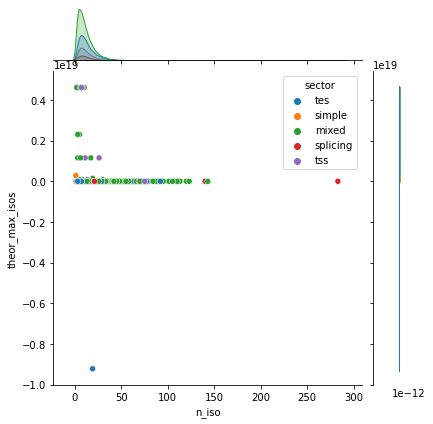

In [127]:
sns.jointplot(data=df, x='n_iso', y='theor_max_isos', hue='sector')

In [128]:
df['frac_max_theor_isos'] = 0
df['frac_max_theor_isos'] = df['frac_max_theor_isos'].astype('float128')
df['frac_max_theor_isos'] = df['n_ic']/df['theor_max_isos']
# df['norm_frac_max_theor_isos'] = df['frac_max_theor_isos']

In [132]:
# remove the -1 ones :/
df = df.loc[df.theor_max_isos > 0]

In [133]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
df['scale_frac_max_theor_isos'] = scaler.fit_transform(df.frac_max_theor_isos.values.reshape(-1,1))

In [134]:
df['scale_frac_max_theor_isos'].head()

5      1.125000e-02
206    2.500000e-03
222    2.812500e-03
469    9.765625e-05
693    6.675720e-08
Name: scale_frac_max_theor_isos, dtype: float64

In [135]:
df.loc[df.gname=='COL1A1']

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,...,gname,sample,gene_tpm,dataset,gene_id,gene_name,n_exons,theor_max_isos,frac_max_theor_isos,scale_frac_max_theor_isos
576886,obs_det,ENSG00000108821,4.0,6.0,5.0,8.0,1.0,0.363636,0.545455,0.090909,...,COL1A1,NaN,NaN,NaN,ENSG00000108821,COL1A1,51,562949953421312,8.881784e-15,7.105080e-16


In [136]:
df.loc[df.gname=='ELN']

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,...,gname,sample,gene_tpm,dataset,gene_id,gene_name,n_exons,theor_max_isos,frac_max_theor_isos,scale_frac_max_theor_isos
106374,obs_det,ENSG00000049540,3.0,7.0,140.0,283.0,28.0,0.078947,0.184211,0.736842,...,ELN,NaN,NaN,NaN,ENSG00000049540,ELN,33,2147483648,6.519258e-08,5.215406e-09


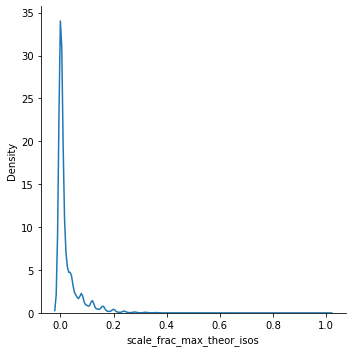

In [137]:
sns.displot(df, x='scale_frac_max_theor_isos',kind='kde')

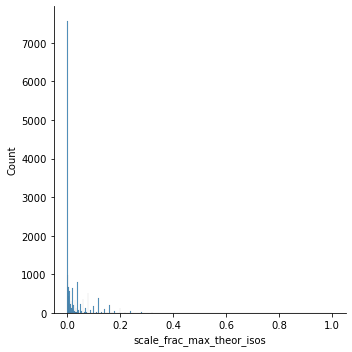

In [138]:
sns.displot(df, x='scale_frac_max_theor_isos')

In [139]:
df.loc[df.scale_frac_max_theor_isos == df.scale_frac_max_theor_isos.max()]
df.loc[df.frac_max_theor_isos>1]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,...,gname,sample,gene_tpm,dataset,gene_id,gene_name,n_exons,theor_max_isos,frac_max_theor_isos,scale_frac_max_theor_isos
6033,obs_det,ENSG00000003249,5.0,2.0,5.0,7.0,1.428571,0.593220,0.237288,0.169492,...,DBNDD1,NaN,NaN,NaN,ENSG00000003249,DBNDD1,4,4,1.25,0.10
12557,obs_det,ENSG00000005022,3.0,2.0,6.0,7.0,2.400000,0.405405,0.270270,0.324324,...,SLC25A5,NaN,NaN,NaN,ENSG00000005022,SLC25A5,4,4,1.50,0.12
13112,obs_det,ENSG00000005075,1.0,2.0,5.0,10.0,3.333333,0.157895,0.315789,0.526316,...,POLR2J,NaN,NaN,NaN,ENSG00000005075,POLR2J,4,4,1.25,0.10
16776,obs_det,ENSG00000005486,3.0,4.0,12.0,15.0,3.428571,0.287671,0.383562,0.328767,...,RHBDD2,NaN,NaN,NaN,ENSG00000005486,RHBDD2,5,8,1.50,0.12
17022,obs_det,ENSG00000005513,3.0,2.0,4.0,6.0,1.600000,0.454545,0.303030,0.242424,...,SOX8,NaN,NaN,NaN,ENSG00000005513,SOX8,3,2,2.00,0.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2469654,obs_det,ENSG00000279301,1.0,3.0,3.0,7.0,1.500000,0.181818,0.545455,0.272727,...,OR2T11,NaN,NaN,NaN,ENSG00000279301,OR2T11,3,2,1.50,0.12
2470816,obs_det,ENSG00000282988,2.0,3.0,4.0,7.0,1.600000,0.303030,0.454545,0.242424,...,ENSG00000282988,NaN,NaN,NaN,ENSG00000282988,ENSG00000282988,3,2,2.00,0.16
2472021,obs_det,ENSG00000283809,1.0,1.0,4.0,4.0,4.000000,0.166667,0.166667,0.666667,...,ENSG00000283809,NaN,NaN,NaN,ENSG00000283809,ENSG00000283809,3,2,2.00,0.16
2472632,obs_det,ENSG00000284308,3.0,3.0,3.0,4.0,1.000000,0.428571,0.428571,0.142857,...,C2orf81,NaN,NaN,NaN,ENSG00000284308,C2orf81,3,2,1.50,0.12


In [140]:
pd.__version__

'1.3.5'

In [48]:
df.loc[(df.theor_max_isos==-1)].sort_values(by='n_exons', ascending=True)

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,...,dataset,gene_id,gene_name,n_exons,theor_max_isos,frag_max_theor_isos,exp_10_frac_max_theor_isos,frac_max_theor_isos,exp_frac_max_theor_isos,scale_frac_max_theor_isos
102963,obs_det,ENSG00000165164,1.0,2.0,2.0,2.0,1.333333,0.230769,0.461538,0.307692,...,NaN,ENSG00000165164,CFAP47,64.0,-1.0,-2.0,1.024000e+03,-2.0,1.024000e+03,0.617021
93402,obs_det,ENSG00000075539,5.0,6.0,9.0,10.0,1.636364,0.395683,0.474820,0.129496,...,NaN,ENSG00000075539,FRYL,64.0,-1.0,-10.0,1.000000e+10,-10.0,1.000000e+10,0.446809
100829,obs_det,ENSG00000149311,6.0,6.0,8.0,8.0,1.333333,0.450000,0.450000,0.100000,...,NaN,ENSG00000149311,ATM,64.0,-1.0,-8.0,1.073742e+09,-8.0,1.073742e+09,0.489362
106197,obs_det,ENSG00000184445,2.0,5.0,6.0,6.0,1.714286,0.229508,0.573770,0.196721,...,NaN,ENSG00000184445,KNTC1,64.0,-1.0,-6.0,6.046618e+07,-6.0,6.046618e+07,0.531915
99928,obs_det,ENSG00000142449,3.0,1.0,2.0,3.0,1.000000,0.600000,0.200000,0.200000,...,NaN,ENSG00000142449,FBN3,64.0,-1.0,-3.0,5.904900e+04,-3.0,5.904900e+04,0.595745
106968,obs_det,ENSG00000189056,4.0,2.0,4.0,7.0,1.333333,0.545455,0.272727,0.181818,...,NaN,ENSG00000189056,RELN,64.0,-1.0,-7.0,2.824752e+08,-7.0,2.824752e+08,0.510638
99481,obs_det,ENSG00000138829,7.0,12.0,17.0,19.0,1.789474,0.336709,0.577215,0.086076,...,NaN,ENSG00000138829,FBN2,65.0,-1.0,-19.0,6.131066e+12,-19.0,6.131066e+12,0.255319
107869,obs_det,ENSG00000204248,1.0,3.0,4.0,5.0,2.000000,0.166667,0.500000,0.333333,...,NaN,ENSG00000204248,COL11A2,66.0,-1.0,-5.0,9.765625e+06,-5.0,9.765625e+06,0.553191
95942,obs_det,ENSG00000111799,10.0,8.0,19.0,31.0,2.111111,0.497238,0.397790,0.104972,...,NaN,ENSG00000111799,COL12A1,66.0,-1.0,-31.0,8.196283e+14,-31.0,8.196283e+14,0.000000
98116,obs_det,ENSG00000130635,5.0,6.0,9.0,25.0,1.636364,0.395683,0.474820,0.129496,...,NaN,ENSG00000130635,COL5A1,66.0,-1.0,-25.0,9.536743e+13,-25.0,9.536743e+13,0.127660


In [ ]:
## How does this compare to the total number of observed isoforms?
## How does this relate to sector identity of each gene?